In [1]:
%matplotlib inline
#import fleks,yt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy import stats
import numpy as np
import os
import re
#from utilities import get_ticks
from matplotlib import cm, ticker
from os import listdir
from os.path import isfile, join
import glob
from PIL import Image
from natsort import natsorted
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy import interpolate
from matplotlib.ticker import LogFormatter 
from matplotlib.ticker import LogLocator, LogFormatterSciNotation 
import tecplot as tp
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from tecplot.exception import *
from tecplot.constant import *
import pandas as pd

In [22]:
# Define Constants
amu = 1.67e-27
k_b = 1.38e-23
mu_0 = 1.257e-6
R_M = 2440e3 #m
m_p = 1.67e-27 # kg

# Define utility functions
def read_dataset(mypath):
    # Reads in file "mypath" and returns a dataset object. May take a while for larger files.

    print("reading:",mypath)
    # First connect to TecPlot
    tp.session.connect()

    # Configure layout
    tp.new_layout()
    dataset = tp.data.load_tecplot(mypath)
    frame = tp.active_frame()
    frame.plot_type = PlotType.Cartesian3D

    # Return dataset
    return dataset

def extract_line(plane,line_start,line_end,num_points=100):
    # Input: 2d slice of domain (cannot be xz plane) format as a dictionary (like output from extract_values_fast), 
    # and the endpoints of a line to extract data for
    # Output: dictionary with same keys as the plane, but for data along the line
    # Does not interpolate, just finds nearest points to the line
    
    # Define arrays for the line
    x_axis = np.linspace(line_start[0],line_end[0],num_points)
    y_axis = np.linspace(line_start[1],line_end[1],num_points)
    
    # Define empty arrays for each value stored in the plane dictionary
    out_dict = {}
    for key in plane.keys():
        out_dict[key]=np.zeros_like(x_axis)
    
    # For each point, find the closest cell and store the values in the out_dict
    for i in range(num_points):
        idx = (np.abs(plane["X"][0,:] - x_axis[i])).argmin()
        idy = (np.abs(plane["Y"][:,0] - y_axis[i])).argmin()
        for key in plane.keys():
            out_dict[key][i] = (plane[key][idy,idx])
    
    return out_dict

def get_files(dir, key=".*cut_particle_region0_0.*"):
    # For a directory "dir", return a list of all files which match the regex expression "key"
    all_files = [f for f in listdir(dir) if isfile(join(dir, f))]
    files=[]
    for file in all_files:
        match = re.search(key,file)
        if match != None:
            files.append(file)
    files.sort()
    # Now give them the appropriate name for their time
    named_files = {}
    for i in range(len(files)):
        time = round(i*dt+start_time,3)
        named_files[time] = files[i]
    # Now cut the list down to files inside t_bound
    reduced_files = {}
    for time in list(named_files.keys())[int((t_bound[0]-start_time)/dt):int((t_bound[1]-start_time)/dt)]: #only loop over the times within t_bound
        reduced_files[time] = str(named_files[time])
    return reduced_files

def convert_to_plt(dir,files):
    # Hand it a directory with the dict of files in it, and it will convert them to .plt and save in dir
    for file in files:
        dataset=read_dataset(str(dir+files[file]))
        print("saving file:",str(dir+files[file][:-3]+"plt"))
        tp.data.save_tecplot_plt(str(dir+files[file][:-3]+"plt"))

def extract_current_surface(path,var_ls=["Bz"]):
    # First, read in the dataset with tecplot
    dataset = read_dataset(path)

    # Extract the coordinate axes
    x_axis = np.unique(dataset.variable("X").values(0).as_numpy_array())
    y_axis = np.unique(dataset.variable("Y").values(0).as_numpy_array())[1:-1]
    z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())

    # Create an ordered zone
    rect_zone = dataset.add_ordered_zone('rect_zone',[len(x_axis),len(y_axis-2),len(z_axis)])

    # Create 3D coordinate meshgrids
    xxx,yyy,zzz = np.meshgrid(x_axis,y_axis,z_axis)

    # Assign coordinate values to the rect_zone using the meshgrids
    rect_zone.values('X')[:] = xxx.ravel()
    rect_zone.values('Y')[:] = yyy.ravel()
    rect_zone.values('Z')[:] = zzz.ravel()

    # Define a list of all the variable indices which will be extracted (doesnt work since we need commas)
    variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

    # Compute current, if requested
    if ("Jx" in var_ls) or ("Jy" in var_ls) or ("Jz" in var_ls):
        print("Computing J = ∇xB")
        tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)',
            ignore_divide_by_zero=True)
        variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33]

        # Also compute pressure gradient
        if "dpS1_dx" in var_ls:
            print("Computing ∇p")
            tp.data.operate.execute_equation(equation='{dpS1_dx} = (ddx({pxxS1}) + ddx({pyyS1}) + ddx({pzzS1}))/3/2440000',
            ignore_divide_by_zero=True)
            tp.data.operate.execute_equation(equation='{dpS1_dy} = (ddy({pxxS1}) + ddy({pyyS1}) + ddy({pzzS1}))/3/2440000',
                ignore_divide_by_zero=True)
            tp.data.operate.execute_equation(equation='{dpS1_dz} = (ddz({pxxS1}) + ddz({pyyS1}) + ddz({pzzS1}))/3/2440000',
                ignore_divide_by_zero=True)
            variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]

        elif "dpS0_dx" in var_ls:
            print("Computing $\nabla p$")
            tp.data.operate.execute_equation(equation='{dpS0_dx} = (ddx({pxxS0}) + ddx({pyyS0}) + ddx({pzzS0}))/3/2440000',
            ignore_divide_by_zero=True)
            tp.data.operate.execute_equation(equation='{dpS0_dy} = (ddy({pxxS0}) + ddy({pyyS0}) + ddy({pzzS0}))/3/2440000',
                ignore_divide_by_zero=True)
            tp.data.operate.execute_equation(equation='{dpS0_dz} = (ddz({pxxS0}) + ddz({pyyS0}) + ddz({pzzS0}))/3/2440000',
                ignore_divide_by_zero=True)
            variable_ls = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36]

    print("Beginning interpolation...")
    # Interpolate onto rect_zone
    tp.data.operate.interpolate_linear(source_zones=[0],
        destination_zone=1,
        variables=variable_ls,
        fill_value=0)

    # Calculate the plasma beta meshgrid
    beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+
                            rect_zone.values("pyyS1").as_numpy_array()+rect_zone.values("pzzS1").as_numpy_array())*1e9/3/(rect_zone.values("Bx").as_numpy_array()**2+rect_zone.values("By").as_numpy_array()**2+rect_zone.values("Bz").as_numpy_array()**2)).reshape(xxx.shape)
    beta_meshgrid[np.isnan(beta_meshgrid)] = 0

    # Define dictionary to save results
    data = {"X":xxx[:,:,0],"Y":yyy[:,:,0]} #, "Z":np.zeros_like(xxx[:,:,0])}

    print("Interpolation complete, searching for max beta and saving data")
    # Interate through each x,y coord to find the max beta on that z-line and save the data
    for name in np.concatenate([["Z"],var_ls]):
        print("Saving var:",name)
        data[name] = np.zeros_like(xxx[:,:,0])
        var = rect_zone.values(name).as_numpy_array().reshape(xxx.shape)
        for idy in range(len(yyy[:,0,0])):
            for idx in range(len(xxx[0,:,0])):
                idz = np.argmax(beta_meshgrid[idy,idx,:])
                data[name][idy,idx] = var[idy,idx,idz]

    print("Complete!")
    return data

def run(plot_preset,particle_type,var_ls=["Bz"],loc=[-1.25,0],test=False):
    # Convert from .dat to .plt if needed
    if convert_first:
        files = get_files(dir,key="3d\_fluid.*\.dat")
        convert_to_plt(dir,files)
    files = get_files(dir,key="3d\_fluid.*\.plt")

    if plot_preset == "timeseries":
        data = plot_timeseries(dir,files,var_ls=var_ls,loc=loc)
        return data

    # Iterate through each file
    all_data = {}
    for time in list(files.keys()): 
        print("Plotting t =",time)
        file = str(files[time])
        
        # Plot according to plot_preset
        if plot_preset == "Bz1_zoom":
            all_data[time] = plot_Bz1_zoom(dir,file,time)

        elif plot_preset == "p_zoom":
            all_data[time] = plot_p_zoom(dir,file,time,particle_type)

        elif plot_preset == "temperature_anisotropy":
            all_data[time] = plot_temperature_anisotropy(dir,file,time,particle_type)

        elif plot_preset == "current_sheet":
            all_data[time] = plot_current_sheet(dir,file,time)

        elif plot_preset == "J_inrt":
            all_data[time] = plot_J_inrt(dir,file,time,particle_type)

        elif plot_preset == "along_line":
            all_data[time] = plot_along_line(dir,file,time,var_ls=var_ls,loc=loc)

        # Abort and return data if test mode
        if test:
            return data

In [25]:
# Plotting functions

def plot_Bz1_zoom(dir,file,time):
        fig, ax = plt.subplots(figsize=(12,9))
        
        # Load in dataset
        #dataset = read_dataset(dir+file)

        # Find current sheet
        data = extract_current_surface(dir+file,var_ls=["Bz"])

        # Unpack variables
        X = data["X"]
        Y = data["Y"]
        Z = data["Z"]
        Bz = data["Bz"]
    
        # Slice out current sheet
        #current_sheet = extract_values_fast(dataset,var_ls=["Bz"],origin=origin,normal=normal)

        # Compute perturbation field, from https://ccmc.gsfc.nasa.gov/static/files/Dipole.pdf
        Bz_dip = - 200.9 * (3*(Z-0.2)**2 - (X**2+Y**2+(Z-0.2)**2))/((X**2+Y**2+(Z-0.2)**2)**(5/2))

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-2.5,-0.5]
        ylims = [-1,1]
        vmin = -60
        vmax = 0
        nlevels = 31 
        levels = np.linspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, (Bz-Bz_dip), levels=levels, cmap='viridis')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax) 
        clb1.ax.tick_params(labelsize=8)
        clb1.ax.set_title('$B_{z1}$ [nT]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str("$B_z-B_{dip}$ in current sheet at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_p_zoom(dir,file,time,particle_type):
        fig, ax = plt.subplots(figsize=(12,9))

        # Find current sheet
        if particle_type=="ion":
            data = extract_current_surface(dir+file,var_ls=["pxxS1","pyyS1","pzzS1"])
            p = data["pxxS1"]+data["pyyS1"]+data["pzzS1"]
        elif particle_type=="electron":
            data = extract_current_surface(dir+file,var_ls=["pxxS0","pyyS0","pzzS0"])
            p = data["pxxS0"]+data["pyyS0"]+data["pzzS0"]

        # Unpack variables
        X = data["X"]
        Y = data["Y"]

        # Plot
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        xlims = [-1.75,-0.75]
        ylims = [-0.5,0.5]
        vmin = -1
        vmax = 1.5
        nlevels = 41 
        levels = np.logspace(vmin, vmax, nlevels)
        cs_plot = ax.contourf(X, Y, p, levels=levels, norm=LogNorm(), cmap='viridis')

        x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
        x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
        y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
        y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

        ax.set_xticks(x_major_ticks)
        ax.set_xticks(x_minor_ticks, minor=True)
        ax.set_yticks(y_major_ticks)
        ax.set_yticks(y_minor_ticks, minor=True)

        ax.grid(which='both')
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        
        #ticks = get_ticks(vmin, vmax)
        clb1 = fig.colorbar(cs_plot, ax=ax,norm=LogNorm())  
        clb1.locator = LogLocator()
        clb1.formatter = LogFormatterSciNotation()   
        clb1.ax.set_title('$p$ [nPa]',fontsize=12)
        ax.set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax.set_xlabel("X [$R_M$]")
        ax.set_ylabel("Y [$R_M$]")
        ax.add_patch(outer)
        ax.add_patch(inner)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        ax.set_title(str(particle_type+"pressure in current sheet at t="+"%.2f"%round(time,2)+"s"))

        # Save
        fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
        plt.close(fig)

        # Hand back data
        return data

def plot_temperature_anisotropy(dir,file,time,particle_type):
    
    fig, ax = plt.subplots(ncols=2,figsize=(15,6))

    # Find current sheet
    if particle_type=="ion":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS1","pxyS1","pxzS1","pyyS1","pyzS1","pzzS1","rhoS1"])
        pxx = data["pxxS1"]
        pxy = data["pxyS1"]
        pxz = data["pxzS1"]
        pyy = data["pyyS1"]
        pyz = data["pyzS1"]
        pzz = data["pzzS1"]
        rho = data["rhoS1"] # its actually number density
    elif particle_type=="electron":
        data = extract_current_surface(dir+file,var_ls=["Bx","By","Bz","Ex","Ey","Ez","pxxS0","pxyS0","pxzS0","pyyS0","pyzS0","pzzS0","rhoS0"])
        pxx = data["pxxS0"]
        pxy = data["pxyS0"]
        pxz = data["pxzS0"]
        pyy = data["pyyS0"]
        pyz = data["pyzS0"]
        pzz = data["pzzS0"]
        rho = data["rhoS0"]*100 # 0.01amu/cc electrons is actually 1 electron/cc
    else:
        print("ERROR: invalid particle type!")

    # Extract field terms
    Bx = data["Bx"]
    By = data["By"]
    Bz = data["Bz"]
    Ex = data["Ex"]
    Ey = data["Ey"]
    Ez = data["Ez"]

    # Compute magnetic unit vector
    B_mag = np.sqrt(Bx**2+By**2+Bz**2)
    bx,by,bz = 1/B_mag * [Bx,By,Bz]

    # Compute magnetic field unit vectors: u,v,b. u is parallel to ExB direction. v = uxb. We already have b.
    # In the end, our new system will be perp1, perp2, para (u,v,b). See back page of space physics 2024 notebook for derivation, or photos from sep. 4, 2024
    # Compute u first, making sure to normalize
    ux,uy,uz = [Ey*Bz-Ez*By, Ez*Bx-Ex*Bz, Ex*By-Ey*Bx]
    ux,uy,uz = 1/np.sqrt(ux**2+uy**2+uz**2)*[ux,uy,uz]

    # Then compute v (already normalized):
    vx,vy,vz = [uy*bz-uz*by, uz*bx-ux*bz, ux*by-uy*bx]

    # We now compute the three diagonal pressure components, using e.g. P_para = b . p . b
    P11 = ux*(pxx*ux+pxy*uy+pxz*uz) + uy*(pxy*ux+pyy*uy+pyz*uz) + uz*(pxz*ux+pyz*uy+pzz*uz)
    P22 = vx*(pxx*vx+pxy*vy+pxz*vz) + vy*(pxy*vx+pyy*vy+pyz*vz) + vz*(pxz*vx+pyz*vy+pzz*vz)
    P33 = bx*(pxx*bx+pxy*by+pxz*bz) + by*(pxy*bx+pyy*by+pyz*bz) + bz*(pxz*bx+pyz*by+pzz*bz)

    # For now, we are interested in the difference parallel (Pzz) and perpendicular (Pxx and Pyy)
    # See Gurnett+Bhattacharjee "Introduction to Plasma Physics: Kinetic Theory and the Moment Equations" p151
    T_perp = (P11+P11)/2/rho/k_b * 1e-9/1e6 # convert from nPa and 1/cm^3
    T_para = (P33)/2/rho/k_b * 1e-9/1e6 # [K]

    # Plot
    xlims = [-2.5,-0.5]
    ylims = [-1,1]
    if particle_type=="ion":
        vmin = 6
        vmax = 8.5
    elif particle_type=="electron":
        vmin = 6
        vmax = 8.5
    nlevels = 21 
    levels = np.logspace(vmin, vmax, nlevels)

    # Plot perp temperature
    cs1 = ax[0].contourf(data["X"],data["Y"],T_perp, cmap='plasma', levels=levels,norm = LogNorm())

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    ax[0].set_xticks(x_major_ticks)
    ax[0].set_xticks(x_minor_ticks, minor=True)
    ax[0].set_yticks(y_major_ticks)
    ax[0].set_yticks(y_minor_ticks, minor=True)

    ax[0].grid(which='both')
    ax[0].grid(which='minor', alpha=0.2)
    ax[0].grid(which='major', alpha=0.5)

    clb1 = fig.colorbar(cs1, ax=ax[0],norm=LogNorm())  
    clb1.locator = LogLocator()
    clb1.formatter = LogFormatterSciNotation()       
    clb1.ax.tick_params(labelsize=8)
    clb1.ax.set_title('$T_{perp}$ [K]',fontsize=12)
    
    ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[0].set_xlabel("X [$R_M$]")
    ax[0].set_ylabel("Y [$R_M$]")
    ax[0].add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax[0].add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_title(str("Perpendicular temperature at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    # Plot para temperature
    cs2 = ax[1].contourf(data["X"],data["Y"],T_para, cmap='plasma',levels=levels,norm = LogNorm())

    ax[1].set_xticks(x_major_ticks)
    ax[1].set_xticks(x_minor_ticks, minor=True)
    ax[1].set_yticks(y_major_ticks)
    ax[1].set_yticks(y_minor_ticks, minor=True)

    ax[1].grid(which='both')
    ax[1].grid(which='minor', alpha=0.2)
    ax[1].grid(which='major', alpha=0.5)
    
    clb2 = fig.colorbar(cs2, ax=ax[1],norm=LogNorm())  
    clb2.locator = LogLocator()
    clb2.formatter = LogFormatterSciNotation()       
    clb2.ax.tick_params(labelsize=8)
    clb2.ax.set_title('$T_{para}$ [K]',fontsize=12)
    
    ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[1].set_xlabel("X [$R_M$]")
    ax[1].set_ylabel("Y [$R_M$]")
    ax[1].add_patch(plt.Circle((0, 0), 1, color='grey'))
    ax[1].add_patch(plt.Circle((0, 0), 0.8, color='black'))
    ax[1].set_xlim(xlims)
    ax[1].set_ylim(ylims)
    ax[1].set_title(str("Parallel temperature at t ="+"%.2f"%round(time,2)+"s"+"\n Particle type: "+particle_type))

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_current_sheet(dir,file,time):
    fig, ax = plt.subplots(ncols=2,figsize=(16,5))
    
    # Load in dataset
    #dataset = read_dataset(dir+file)

    # Find current sheet
    data = extract_current_surface(dir+file,var_ls=["Bz"])

    # Unpack variables
    X = data["X"]
    Y = data["Y"]
    Z = data["Z"]
    Bz = data["Bz"]

    # Plot left view
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')

    xlims = [-3.5,-0.5]
    ylims = [-1,1]
    xz_plot = ax[0].scatter(X[::-1,::-1], Z[::-1,::-1], c = Y[::-1,::-1], vmin=-1,vmax=1, cmap='bwr',alpha=0.5)

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    ax[0].set_xticks(x_major_ticks)
    ax[0].set_xticks(x_minor_ticks, minor=True)
    ax[0].set_yticks(y_major_ticks)
    ax[0].set_yticks(y_minor_ticks, minor=True)

    ax[0].grid(which='both')
    ax[0].grid(which='minor', alpha=0.2)
    ax[0].grid(which='major', alpha=0.5)
    
    #ticks = get_ticks(vmin, vmax)
    clb1 = fig.colorbar(xz_plot, ax=ax[0]) 
    clb1.ax.tick_params(labelsize=8)
    clb1.ax.set_title('$Y$ [$R_M$]',fontsize=12)
    ax[0].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[0].set_xlabel("X [$R_M$]")
    ax[0].set_ylabel("Z [$R_M$]")
    ax[0].add_patch(outer)
    ax[0].add_patch(inner)
    ax[0].set_xlim(xlims)
    ax[0].set_ylim(ylims)
    ax[0].set_title(str("Current sheet in XZ plane at t="+"%.2f"%round(time,2)+"s"))

    # Plot right view
    inner = plt.Circle((0, 0), 0.8, color='black')
    outer = plt.Circle((0, 0), 1, color='grey')

    vmin = -0.5
    vmax = 0.5
    nlevels = 23 
    levels = np.linspace(vmin, vmax, nlevels)
    xy_plot = ax[1].contourf(X, Y, (Z-0.2), levels=levels, cmap='bwr')

    ax[1].set_xticks(x_major_ticks)
    ax[1].set_xticks(x_minor_ticks, minor=True)
    ax[1].set_yticks(y_major_ticks)
    ax[1].set_yticks(y_minor_ticks, minor=True)

    ax[1].grid(which='both')
    ax[1].grid(which='minor', alpha=0.2)
    ax[1].grid(which='major', alpha=0.5)
    
    #ticks = get_ticks(vmin, vmax)
    clb2 = fig.colorbar(xy_plot, ax=ax[1]) 
    clb2.ax.tick_params(labelsize=8)
    clb2.ax.set_title('$(Z-0.2)$ [$R_M$]',fontsize=12)
    ax[1].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
    ax[1].set_xlabel("X [$R_M$]")
    ax[1].set_ylabel("Y [$R_M$]")
    ax[1].add_patch(outer)
    ax[1].add_patch(inner)
    ax[1].set_xlim(xlims)
    ax[1].set_ylim(ylims)
    ax[1].set_title(str("Current sheet in XY plane at t="+"%.2f"%round(time,2)+"s"))

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_J_inrt(dir,file,time,particle_type):
    
    fig, ax = plt.subplots(ncols=3,nrows=2,figsize=(25,13))

    # Get files for later reference
    files = get_files(dir,key="3d\_fluid.*\.plt")

    # Slice out current sheet, get velocity data
    if particle_type=="ion":
        data = extract_current_surface(dir+file,var_ls=["rhoS1","uxS1","uyS1","uzS1","Bx","By","Bz","Jx","Jy","Jz","dpS1_dx","dpS1_dy","dpS1_dz"])
        rho = data["rhoS1"] # amu/cc
        ux,uy,uz = (data["uxS1"],data["uyS1"],data["uzS1"]) # km/s
        dp_dx,dp_dy,dp_dz = (data["dpS1_dx"],data["dpS1_dy"],data["dpS1_dz"]) # nPa/m
    elif particle_type=="electron":
        data = extract_current_surface(dir+file,var_ls=["rhoS0","uxS0","uyS0","uzS0","Bx","By","Bz","Jx","Jy","Jz","dpS0_dx","dpS0_dy","dpS0_dz"])
        rho = data["rhoS0"]
        ux,uy,uz = (data["uxS0"],data["uyS0"],data["uzS0"])
        dp_dx,dp_dy,dp_dz = (data["dpS0_dx"],data["dpS0_dy"],data["dpS0_dz"]) # nPa/m
    else:
        print("invalid particle type!")
    Bx,By,Bz = (data["Bx"],data["By"],data["Bz"]) #nT
    Jx,Jy,Jz = (data["Jx"],data["Jy"],data["Jz"]) #micro A/m^2
    B_mag = np.sqrt(Bx**2+By**2+Bz**2)

    # COmpute the grad_P current
    prefactor = 1/(B_mag*1e-9)**2 
    prefactor[np.isnan(prefactor)] = 0

    J_gradP_x = prefactor * (1e-18) * (By*dp_dz - Bz*dp_dy)
    J_gradP_y = prefactor * (1e-18) * (Bz*dp_dx - Bx*dp_dz)
    J_gradP_z = prefactor * (1e-18) * (Bx*dp_dy - By*dp_dx)

     # If this is the first time-step, then we cannot compute the derivative for J_inrt
    if time == start_time:
        print("first time step! Cannot compute derivative")
        J_inrt_x = np.zeros_like(ux) 
        J_inrt_y = np.zeros_like(ux) 
        J_inrt_z = np.zeros_like(ux) 
        
    else: # In other cases, go ahead and compute du/dt as (u-u_prev)/dt
        # To do this, we will re-read in the previous time step using the present current sheet fit
        if particle_type=="ion":
            data_prev = extract_current_surface(dir+str(files[round(time-dt,3)]),var_ls=["uxS1","uyS1","uzS1"])
            ux_prev,uy_prev,uz_prev = (data_prev["uxS1"],data_prev["uyS1"],data_prev["uzS1"])
        else:
            data_prev = extract_current_surface(dir+str(files[round(time-dt,3)]),var_ls=["uxS0","uyS0","uzS0"])
            ux_prev,uy_prev,uz_prev = (data_prev["uxS0"],data_prev["uyS0"],data_prev["uzS0"])
            
        dux_dt = (ux-ux_prev)/dt # km/s^2
        duy_dt = (uy-uy_prev)/dt
        duz_dt = (uz-uz_prev)/dt

        J_inrt_x = (rho*m_p) * prefactor * (By*duz_dt - Bz*duy_dt)
        J_inrt_y = (rho*m_p) * prefactor * (Bz*dux_dt - Bx*duz_dt)
        J_inrt_z = (rho*m_p) * prefactor * (Bx*duy_dt - By*dux_dt)

    xlims = [-2.5,-0.5]
    ylims = [-1,1]

    x_major_ticks = np.arange(xlims[0], xlims[1], 0.25)
    x_minor_ticks = np.arange(xlims[0], xlims[1], 0.05)
    y_major_ticks = np.arange(ylims[0], ylims[1], 0.25)
    y_minor_ticks = np.arange(ylims[0], ylims[1], 0.05)

    # J_inrt plot
    plot_ls = [J_inrt_x,J_inrt_y,J_inrt_z]
    vmin = -1.2
    vmax = 1.2
    nlevels = 31 
    levels = np.linspace(vmin, vmax, nlevels)
    
    for i in range(len(plot_ls)):
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        plot = ax[0,i].contourf(data['X'], data['Y'], plot_ls[i]*1e6, levels=levels, cmap='bwr')
        
        #clb = fig.colorbar(plot, ax=ax[i])  
        #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
    
        ax[0,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[0,i].set_xlabel("X [$R_M$]")
        ax[0,i].set_ylabel("Y [$R_M$]")
        ax[0,i].add_patch(outer)
        ax[0,i].add_patch(inner)
        ax[0,i].set_xlim(xlims)
        ax[0,i].set_ylim(ylims)
        ax[0,i].set_xticks(x_major_ticks)
        ax[0,i].set_xticks(x_minor_ticks, minor=True)
        ax[0,i].set_yticks(y_major_ticks)
        ax[0,i].set_yticks(y_minor_ticks, minor=True)
        ax[0,i].grid(which='both')
        ax[0,i].grid(which='minor', alpha=0.2)
        ax[0,i].grid(which='major', alpha=0.5)
        ax[0,i].set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ at t="+str(round(time,2))+"s"))

    fig.subplots_adjust(right=0.8)
    cbar1 = fig.colorbar(plot, ax=ax[0,:], shrink=0.8)
    cbar1.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=12)
    
    #J_gradP plot
    plot_ls = [J_gradP_x,J_gradP_y,J_gradP_z]
    vmin = -1.2
    vmax = 1.2
    nlevels = 31 
    levels = np.linspace(vmin, vmax, nlevels)
    
    for i in range(len(plot_ls)):
        inner = plt.Circle((0, 0), 0.8, color='black')
        outer = plt.Circle((0, 0), 1, color='grey')

        plot = ax[1,i].contourf(data['X'], data['Y'], plot_ls[i]*1e6, levels=levels, cmap='bwr')
        
        #clb = fig.colorbar(plot, ax=ax[i])  
        #clb.ax.set_title(str("$J_{inrt,"+str(["x","y","z"][i])+"}$ [μA/m$^2$]"),fontsize=12)
    
        ax[1,i].set_aspect(1) # you may also use am.imshow(..., aspect="auto") to restore the aspect ratio
        ax[1,i].set_xlabel("X [$R_M$]")
        ax[1,i].set_ylabel("Y [$R_M$]")
        ax[1,i].add_patch(outer)
        ax[1,i].add_patch(inner)
        ax[1,i].set_xlim(xlims)
        ax[1,i].set_ylim(ylims)
        ax[1,i].set_xticks(x_major_ticks)
        ax[1,i].set_xticks(x_minor_ticks, minor=True)
        ax[1,i].set_yticks(y_major_ticks)
        ax[1,i].set_yticks(y_minor_ticks, minor=True)
        ax[1,i].grid(which='both')
        ax[1,i].grid(which='minor', alpha=0.2)
        ax[1,i].grid(which='major', alpha=0.5)
        ax[1,i].set_title(str("$J_{grad(P),"+str(["x","y","z"][i])+"}$ at t="+str(round(time,2))+"s"))

    cbar2 = fig.colorbar(plot, ax=ax[1, :], shrink=0.8)
    cbar2.ax.set_title(str("$J$ [μA/m$^2$]"),fontsize=12)

    # Save
    fig.savefig(str(str(dir[:-1])+"_plots/"+particle_type+"_"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return data

def plot_timeseries(dir,files,var_ls=["Bz"],loc=[-1.25,0]):
    # Steps through all the files, pulling the requested data at loc to plot a timeseries
    
    # Declare a dictionary to save all the data as we gather it
    time_data = {"t":list(files.keys())}
    
    # Save a list for each variable, which is as long as the number of files to be read (i.e. number of timesteps)
    for var in var_ls:
        time_data[var] = np.zeros(len(list(files.keys())))
    
    # Step through each file, saving the data
    it = 0
    for time in list(files.keys()): 

        # Read in dataset
        print("Pulling data for time",time,"from file",files[time])
        dataset = read_dataset(dir+files[time])

        # Compute any extra variables
        if "Jx" in var_ls:
            tp.data.operate.execute_equation(equation='{Jx} = (ddy({Bz}) - ddz({By}))/(1.2566*10**(-6))/2440000*10**(-9)*1e6',
                ignore_divide_by_zero=True) # CONVERTED TO uA ALREADY
        elif "Jy" in var_ls:
            tp.data.operate.execute_equation(equation='{Jy} = (ddz({Bx}) - ddx({Bz}))/(1.2566*10**(-6))/2440000*10**(-9)*1e6',
                ignore_divide_by_zero=True)
        elif "Jz" in var_ls:
            tp.data.operate.execute_equation(equation='{Jz} = (ddx({By}) - ddy({Bx}))/(1.2566*10**(-6))/2440000*10**(-9)*1e6',
                ignore_divide_by_zero=True)

        # To find the current sheet, we need to find the max beta along the xy line of interest
        # Borrowing some code from PC_plotting/find_current_surface
        z_axis = np.unique(dataset.variable("Z").values(0).as_numpy_array())
        x_axis = np.zeros(len(z_axis))+loc[0]
        y_axis = np.zeros(len(z_axis))+loc[1]
        line = tp.data.extract.extract_line(zip(x_axis,y_axis,z_axis))

        # Compute beta along the line
        beta = (2*mu_0*(line.values("pxxS0").as_numpy_array()+line.values("pyyS0").as_numpy_array()+
                        line.values("pzzS0").as_numpy_array()+line.values("pxxS1").as_numpy_array()+
                        line.values("pyyS1").as_numpy_array()+
                        line.values("pzzS1").as_numpy_array())*1e9/3/(line.values("Bx").as_numpy_array()**2+
                        line.values("By").as_numpy_array()**2+line.values("Bz").as_numpy_array()**2))

        # Find index of max beta, corresponding to z coord of current sheet
        idz = np.argmax(beta)
        print("found current sheet at",line.values("X").as_numpy_array()[idz],line.values("Y").as_numpy_array()[idz],line.values("Z").as_numpy_array()[idz])

        # Save the necessary data to time_data, many are special cases
        for var in var_ls:
            if var=="p_ion":
                time_data[var][it] = (line.values("pxxS1").as_numpy_array()[idz]+line.values("pyyS1").as_numpy_array()[idz]+line.values("pzzS1").as_numpy_array()[idz])/3
            else:
                time_data[var][it] = line.values(var).as_numpy_array()[idz]
                
        
        it+=1

    # Plot the results
    fig, axs = plt.subplots(ncols=1,nrows=len(var_ls),figsize=(16,4*len(var_ls)))

    # Step through each subplot
    for i in range(len(axs)):

        axs[i].plot(time_data["t"],time_data[var_ls[i]])
        
        # Magnetic field plotting
        if (var_ls[i] == "Bx") or (var_ls[i] == "By") or (var_ls[i] == "Bz"):
            axs[i].plot(time_data["t"],time_data[var_ls[i]])
            axs[i].set_ylabel(str("$B_"+str(var_ls[i][-1])+"$ [nT]"))
        
        # Pressure plotting
        elif (var_ls[i] == "p_ion") or (var_ls[i] == "p_electron"):
            axs[i].set_ylabel(str("$p_{"+str(var_ls[i][2:])+"}$ [nPa]"))

        # Ion velocity plotting
        elif (var_ls[i] == "uxS1") or (var_ls[i] == "uyS1") or (var_ls[i] == "uzS1"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",ion}$ [km/s]"))

        # Electron velocity plotting
        elif (var_ls[i] == "uxS0") or (var_ls[i] == "uyS0") or (var_ls[i] == "uzS0"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",electron}$ [km/s]"))

        # Current plotting
        elif (var_ls[i] == "Jx") or (var_ls[i] == "Jy") or (var_ls[i] == "Jz"):
            axs[i].set_ylabel(str("$J_{"+str(var_ls[i][1])+"}$ [μA/m$^2$]"))

        axs[i].set_xlabel("Time [s]")

    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return time_data

def plot_along_line(dir,file,time,var_ls=["Bz"],loc=[[-1.5,0],[-1.1,0]]):
    # Plot all the variables in var_ls along a line segment given by loc
    #loc should be format as [[x_start,y_start], [x_end,y_end]]
    
    # Load in dataset
    data = extract_current_surface(dir+file,var_ls=var_ls)

    # Cast data onto a line
    line = extract_line(data,loc[0],loc[1])
    line["r"] = np.sqrt(line["X"]**2+line["Y"]**2+line["Z"]**2) # Distance from origin
    line["s"] = np.sqrt((line["X"]-line["X"][0])**2+(line["Y"]-line["Y"][0])**2+(line["Z"]-line["Z"][0])**2) # Path length alone line
    
    # Plot the results
    fig, axs = plt.subplots(ncols=1,nrows=len(var_ls),figsize=(16,4*len(var_ls)))

    # Step through each subplot
    for i in range(len(axs)):

        axs[i].plot(line["s"],line[var_ls[i]])
        
        # Magnetic field plotting
        if (var_ls[i] == "Bx") or (var_ls[i] == "By") or (var_ls[i] == "Bz"):
            axs[i].set_ylabel(str("$B_"+str(var_ls[i][-1])+"$ [nT]"))
        
        # Pressure plotting
        elif (var_ls[i] == "p_ion") or (var_ls[i] == "p_electron"):
            axs[i].set_ylabel(str("$p_{"+str(var_ls[i][2:])+"}$ [nPa]"))

        # Ion velocity plotting
        elif (var_ls[i] == "uxS1") or (var_ls[i] == "uyS1") or (var_ls[i] == "uzS1"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",ion}$ [km/s]"))

        # Electron velocity plotting
        elif (var_ls[i] == "uxS0") or (var_ls[i] == "uyS0") or (var_ls[i] == "uzS0"):
            axs[i].set_ylabel(str("$u_{"+str(var_ls[i][1])+",electron}$ [km/s]"))

        # Current plotting
        elif (var_ls[i] == "Jx") or (var_ls[i] == "Jy") or (var_ls[i] == "Jz"):
            axs[i].set_ylabel(str("$J_{"+str(var_ls[i][1])+"}$ [μA/m$^2$]"))

        axs[i].set_xlabel("Path length [km]")
        axs[0].set_title("Parameters along line from",loc[0],"to",loc[1])

    fig.savefig(str(str(dir[:-1])+"_plots/"+plot_preset+"_"+"%.2f"%round(time,2)+'.png'),bbox_inches='tight')
    plt.close(fig)

    # Hand back data
    return time_data
        
#for time in list(files.keys()): 

In [26]:
# High-level user input 
dir = "/Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run5/ta-2/"    # Directory with data 
start_time = 16                                                # What is the start time of the dataset?
t_bound = [16,23]                                               # Start and stop times for the GIF
dt = 0.05                                                     # What is the timestep between files?
convert_first = True # Set to true if files have not yet been converted from .dat to .plt. Otherwise, set as false.

plot_preset = "along_line"
particle_type = "ion"
var_ls = ["p_ion","Bz","uxS1"]
loc = [[-1.5,0],[-1.1,0]]

'''
"Bz1_zoom":  Bz-Bz_dip in current sheet, zoomed to near-planet region and targeted to recognize DFs

"p_zoom":  electron or ion pressure in current sheet, zoomed to near-planet region and targeted to recognize DFs

"temperature_anisotropy": double plot of parallel and perpendicular temperatures, assuming dual maxwellian. Manually changed to use current_surface

"current_sheet": side and top view of current sheet fit

"J_inrt": computation of B/B^2 x rho du/dt current in 2d fit current sheet

"timeseries": given var_ls and loc, it plots out those values at all times at that point. 
                Uses: var_ls, loc = [x,y]

"along_line": given var_ls and loc, it plots out those values at all times at that point. 
                Uses: var_ls, loc = [[x_start,y_start] , [x_end,y_end]]
'''

data = run(plot_preset,particle_type,var_ls=var_ls,loc=loc,test=False)



Plotting t = 16.0
reading: /Users/atcushen/Documents/MercuryModelling/runs/nightside_v1_run5/ta-2/3d_fluid_region0_0_t00000016_n00010395_amrex.plt
Connecting to Tecplot 360 TecUtil Server on:
    tcp://localhost:7600
Connection established.
Beginning interpolation...


/var/folders/l9/dnt9qhfd1psfsmj9t5zfr0j00000gq/T/ipykernel_60919/2348225994.py:139: RuntimeWarning: invalid value encountered in divide
  beta_meshgrid = (2*mu_0*(rect_zone.values("pxxS0").as_numpy_array()+rect_zone.values("pyyS0").as_numpy_array()+rect_zone.values("pzzS0").as_numpy_array()+rect_zone.values("pxxS1").as_numpy_array()+


Interpolation complete, searching for max beta and saving data
Saving var: Z
Saving var: p_ion


AttributeError: 'NoneType' object has no attribute 'index'

In [17]:
x=data
np.unique(x)

KeyError: 0

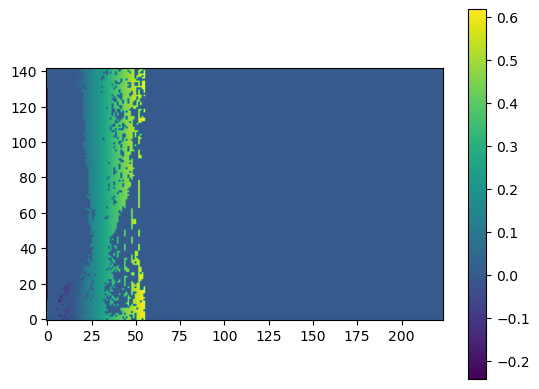

In [19]:
plt.imshow(data["Z"],origin="lower") 
plt.colorbar()

In [5]:
ls = [1,2,3]

In [6]:
if 2 in ls:
    print('yes')

yes
